In [249]:
from datetime import datetime
import os
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from scipy import sparse
from scipy.sparse import csc_matrix
from sklearn.decomposition import TruncatedSVD

np.random.seed(0)

### Book  Dataset
https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset


In [250]:
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [251]:
!gdown https://drive.google.com/uc?id=1TE3vZZf0yq9J2sTbDFL7BFNCDQIG6Nd-

Downloading...
From: https://drive.google.com/uc?id=1TE3vZZf0yq9J2sTbDFL7BFNCDQIG6Nd-
To: /content/Books.zip
100% 25.0M/25.0M [00:00<00:00, 320MB/s]


In [252]:
#!unzip "Books.zip"  -d  "/content"

In [253]:
rating_df = pd.read_csv('Ratings.csv')
book_df = pd.read_csv('Books.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


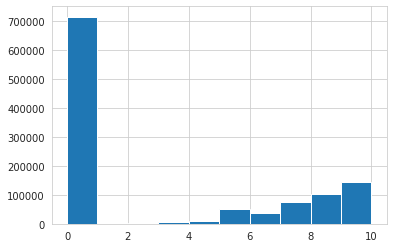

In [254]:
rating_df=pd.merge(rating_df,book_df,on="ISBN",how="left")
rating_df['Book-Rating'].hist()

In [255]:
y = rating_df.groupby('Book-Title').count()['Book-Rating']>=100
books = y[y].index
rating_df = rating_df[rating_df['Book-Title'].isin(books)]

In [256]:
x = rating_df.groupby('User-ID').count()['Book-Rating'] > 100
userIndex = x[x].index
rating_df=rating_df[rating_df['User-ID'].isin(userIndex)]


In [257]:
rating_df=rating_df.dropna()

In [258]:
rating_df=rating_df[['User-ID','Book-Title','Book-Author','Book-Rating']]
rating_df.rename(columns = {'User-ID':'userID', 'Book-Title':'itemID','Book-Author':'author','Book-Rating':'rating'}, inplace = True)

In [259]:

rating_df["itemID"] = rating_df["itemID"].astype(str)
rating_df["userID"] = rating_df["userID"].astype(str)
rating_df["author"] = rating_df["author"].astype(str)

### Prepare dataset

In [260]:
unique_users = rating_df.userID.unique()
user_ids = dict(zip(unique_users, np.arange(unique_users.shape[0], dtype=np.int32)))

unique_items = rating_df.itemID.unique()
item_ids = dict(zip(unique_items, np.arange(unique_items.shape[0], dtype=np.int32)))

In [261]:
product_ids = list(set(list(rating_df.itemID.unique())))
user_ids = list(set(list(rating_df.userID.unique())))

### Look at distribution of ratings

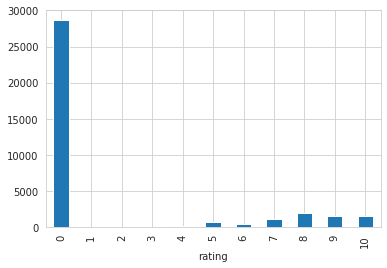

In [262]:
rating_df.groupby(['rating']).size().plot(kind = "bar")

In [263]:
!pip install tensorflow-recommenders==0.6.0

import os
import pprint
import tempfile

from typing import Dict, Text

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds

import tensorflow_recommenders as tfrs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Prepare dataset for tensorflow recommenders

In [264]:
ratings = tf.data.Dataset.from_tensor_slices(dict(rating_df)).map(lambda x: {
    "userID": x["userID"],
    "itemID": x["itemID"],
    "author": x["author"],
    "rating": x["rating"]
})


In [265]:

items =ratings.batch(rating_df.shape[0]).map(lambda x: x["itemID"])
user_ids = ratings.batch(rating_df.shape[0]).map(lambda x: x["userID"])
unique_user_ids = np.unique(np.concatenate(list(user_ids)))
unique_item_ids = np.unique(np.concatenate(list(items)))
products_dict = rating_df[['itemID']].drop_duplicates()
products_dict = {name: np.array(value) for name, value in products_dict.items()}
products = tf.data.Dataset.from_tensor_slices(products_dict)
products = products.map(lambda x: x['itemID'])


In [266]:
userIds    = rating_df.userID.unique()
productIds = rating_df.itemID.unique()
total_ratings= len(rating_df.index)

In [267]:
# ratings = tf.data.Dataset.from_tensor_slices( {"userID":tf.cast( rating_df.userID.values  ,tf.string),
#                                 "itemID":tf.cast( rating_df.itemID.values,tf.string),
#                                 "rating":tf.cast( rating_df.rating.values  ,tf.int8,) } )

In [268]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take( int(total_ratings*0.8) )
test = shuffled.skip(int(total_ratings*0.8)).take(int(total_ratings*0.2))

unique_productIds = productIds
unique_userIds    = userIds
cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

### Tensorflow Ranking 

In [269]:
import numpy as np
import tensorflow as tf
import tensorflow_recommenders as tfrs
# Build a model.
class RankingModel(tf.keras.Model):

    def __init__(self):
        super().__init__()
        embedding_dimension = 32

        self.user_embeddings = tf.keras.Sequential([
                                    tf.keras.layers.experimental.preprocessing.StringLookup(
                                        vocabulary=unique_user_ids, mask_token=None),
                                        # add addional embedding to account for unknow tokens
                                    tf.keras.layers.Embedding(len(unique_user_ids)+1, embedding_dimension)
                                    ])

        self.product_embeddings = tf.keras.Sequential([
                                    tf.keras.layers.experimental.preprocessing.StringLookup(
                                        vocabulary=unique_item_ids, mask_token=None),
                                    # add addional embedding to account for unknow tokens
                                    tf.keras.layers.Embedding(len(unique_item_ids)+1, embedding_dimension)
                                    ])
        # Set up a retrieval task and evaluation metrics over the
        # entire dataset of candidates.
        self.ratings = tf.keras.Sequential([
                            tf.keras.layers.Dense(256, activation="relu"),
                            tf.keras.layers.Dense(64,  activation="relu"),
                            tf.keras.layers.Dense(1)
                              ])
    def call(self, userId, productId):
        user_embeddings  = self.user_embeddings (userId)
        product_embeddings = self.product_embeddings(productId)
        return self.ratings(tf.concat([user_embeddings,product_embeddings], axis=1))

# Build a model.
class BuildModelRanking(tfrs.models.Model):

    def __init__(self):
        super().__init__()
        self.ranking_model: tf.keras.Model = RankingModel()
        self.task: tf.keras.layers.Layer   = tfrs.tasks.Ranking(
                                                    loss    =  tf.keras.losses.MeanSquaredError(),
                                                    metrics = [tf.keras.metrics.RootMeanSquaredError()])
            

    def compute_loss(self, features, training=False):
        rating_predictions = self.ranking_model(features["userID"], features["itemID"]  )

        return self.task( labels=features["rating"], predictions=rating_predictions)

In [270]:
modelranking = BuildModelRanking()
modelranking.compile(optimizer=tf.keras.optimizers.Adagrad( learning_rate=0.1 ))

ranking_history=modelranking.fit(cached_train, epochs=20)

Epoch 1/20
4/4 [==============================] - 1s 27ms/step - root_mean_squared_error: 3.5054 - loss: 12.1806 - regularization_loss: 0.0000e+00 - total_loss: 12.1806
Epoch 2/20
4/4 [==============================] - 0s 6ms/step - root_mean_squared_error: 3.3606 - loss: 11.3295 - regularization_loss: 0.0000e+00 - total_loss: 11.3295
Epoch 3/20
4/4 [==============================] - 0s 6ms/step - root_mean_squared_error: 3.3281 - loss: 11.1343 - regularization_loss: 0.0000e+00 - total_loss: 11.1343
Epoch 4/20
4/4 [==============================] - 0s 6ms/step - root_mean_squared_error: 3.2954 - loss: 10.9023 - regularization_loss: 0.0000e+00 - total_loss: 10.9023
Epoch 5/20
4/4 [==============================] - 0s 6ms/step - root_mean_squared_error: 3.2743 - loss: 10.6956 - regularization_loss: 0.0000e+00 - total_loss: 10.6956
Epoch 6/20
4/4 [==============================] - 0s 6ms/step - root_mean_squared_error: 3.2050 - loss: 10.2520 - regularization_loss: 0.0000e+00 - total_loss:

In [271]:
metrics = modelranking.evaluate(cached_test, return_dict=True)


2/2 [==============================] - 0s 20ms/step - root_mean_squared_error: 3.0579 - loss: 9.4156 - regularization_loss: 0.0000e+00 - total_loss: 9.4156


In [272]:
user_rand = userIds[1]
test_rating = {}
for m in test.take(5):
    test_rating[m["itemID"].numpy()]=RankingModel()(tf.convert_to_tensor([user_rand]),tf.convert_to_tensor([m["itemID"]]))

In [273]:
print("Top 5 recommended products for User {}: ".format(user_rand))
for m in sorted(test_rating, key=test_rating.get, reverse=True):
    print(m.decode())

Top 5 recommended products for User 278418: 
Vinegar Hill (Oprah's Book Club (Paperback))
Tell No One
Heartbreaker
The Witching Hour (Lives of the Mayfair Witches)
Silence of the Lambs


### Muti task Both  Retrieval and Ranking 

In [274]:
class BuildModelMultitask(tfrs.models.Model):

  def __init__(self, rating_weight: float, retrieval_weight: float) -> None:
    # We take the loss weights in the constructor: this allows us to instantiate
    # several model objects with different loss weights.

    super().__init__()

    embedding_dimension = 32

    # User and movie models.
    self.item_model: tf.keras.layers.Layer = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_item_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_item_ids) + 1, embedding_dimension)
    ])
    self.user_model: tf.keras.layers.Layer = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
    ])

    # Model to take in user and item embeddings and predict ratings.
    self.rating_model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(1),
    ])

    # The tasks.
    self.rating_task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.RootMeanSquaredError()],
    )
    self.retrieval_task: tf.keras.layers.Layer = tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidates=items.map(self.item_model)
        )
    )

    # The loss weights.
    self.rating_weight = rating_weight
    self.retrieval_weight = retrieval_weight

  def call(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:
    # We pick out the user features and pass them into the user model.
    user_embeddings = self.user_model(features["userID"])
    # And pick out the movie features and pass them into the movie model.
    item_embeddings = self.item_model(features["itemID"])

    return (
        user_embeddings,
        item_embeddings,
        # We apply the multi-layered rating model to a concatentation of
        # user and movie embeddings.
        self.rating_model(
            tf.concat([user_embeddings, item_embeddings], axis=1)
        ),
    )

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:

    ratings = features.pop("rating")

    user_embeddings,item_embeddings, rating_predictions = self(features)

    # We compute the loss for each task.
    rating_loss = self.rating_task(
        labels=ratings,
        predictions=rating_predictions,
    )
    retrieval_loss = self.retrieval_task(user_embeddings, item_embeddings)

    # And combine them using the loss weights.
    return (self.rating_weight * rating_loss
            + self.retrieval_weight * retrieval_loss)

In [275]:
modelmultitask = BuildModelMultitask(rating_weight=1.0, retrieval_weight=0.0)
modelmultitask.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

In [276]:
modelhist_multitask=modelmultitask.fit(cached_train, epochs=20)
metrics = modelmultitask.evaluate(cached_test, return_dict=True)

print(f"Retrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}.")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}.")

Epoch 1/20
4/4 [==============================] - 8s 2s/step - root_mean_squared_error: 3.5051 - factorized_top_k/top_1_categorical_accuracy: 3.4338e-04 - factorized_top_k/top_5_categorical_accuracy: 3.4338e-04 - factorized_top_k/top_10_categorical_accuracy: 3.4338e-04 - factorized_top_k/top_50_categorical_accuracy: 0.0014 - factorized_top_k/top_100_categorical_accuracy: 0.0025 - loss: 12.1322 - regularization_loss: 0.0000e+00 - total_loss: 12.1322
Epoch 2/20
4/4 [==============================] - 8s 2s/step - root_mean_squared_error: 3.3702 - factorized_top_k/top_1_categorical_accuracy: 4.4640e-04 - factorized_top_k/top_5_categorical_accuracy: 4.4640e-04 - factorized_top_k/top_10_categorical_accuracy: 4.4640e-04 - factorized_top_k/top_50_categorical_accuracy: 0.0013 - factorized_top_k/top_100_categorical_accuracy: 0.0029 - loss: 11.3682 - regularization_loss: 0.0000e+00 - total_loss: 11.3682
Epoch 3/20
4/4 [==============================] - 8s 2s/step - root_mean_squared_error: 3.3211

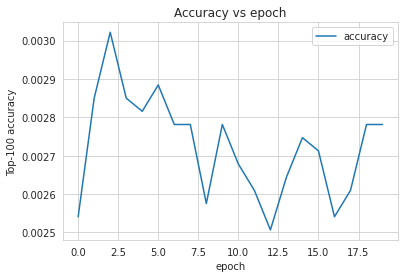

In [277]:
epochs = [i for i in range(20)]

plt.plot(epochs, modelhist_multitask.history["factorized_top_k/top_100_categorical_accuracy"], label="accuracy")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-100 accuracy");
plt.legend()

### Deep cross network

In [278]:
rating_df

,userID,itemID,author,rating
1456,277427,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,10
1468,277427,A Tree Grows in Brooklyn,Betty Smith,0
1469,277427,The Poisonwood Bible: A Novel,Barbara Kingsolver,0
1471,277427,Bel Canto: A Novel,Ann Patchett,0
1474,277427,One for the Money (Stephanie Plum Novels (Pape...,Janet Evanovich,9
...,...,...,...,...
1147441,275970,Morality for Beautiful Girls (No.1 Ladies Dete...,Alexander McCall Smith,0
1147516,275970,An Instance of the Fingerpost,Iain Pears,0
1147517,275970,Fingersmith,Sarah Waters,0
1147556,275970,Me Talk Pretty One Day,David Sedaris,9


In [279]:
epochs = 20
learning_rate = 0.001

In [280]:
interactions_dict = rating_df.groupby(['userID', 
                                      'itemID',
                                      'author'
                                      ])[ 'rating'].sum().reset_index()


In [281]:
interactions_dict = {name: np.array(value) for name, value in interactions_dict.items()}
interactions = tf.data.Dataset.from_tensor_slices(interactions_dict)

## item features
items_dict = rating_df[['itemID']].drop_duplicates()
items_dict = {name: np.array(value) for name, value in items_dict.items()}
items = tf.data.Dataset.from_tensor_slices(items_dict)

## map the features in interactions and items

# Select the basic features.
interactions = interactions.map(lambda x: {
    'userID' : str(x['userID']), 
    'author' : str(x['author']),
    'itemID' : str(x['itemID']), 
    'rating' : int(x['rating']),
    
})

items = items.map(lambda x: str(x['itemID']))
authors = interactions.map(lambda x: str(x['author']))

In [282]:
unique_items = np.unique(np.concatenate(list(items.batch(1000))))
unique_user_ids = np.unique(np.concatenate(list(interactions.batch(1_000).map(lambda x: x["userID"]))))
unique_authors = np.unique(np.concatenate(list(interactions.batch(1_000).map(lambda x: x["author"]))))

In [283]:
total=interactions.__len__().numpy()
train_size=(int) (total * .8 )
test_size=(int) (total * .2 )

In [284]:
tf.random.set_seed(42)
shuffled = interactions.shuffle(train_size, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(train_size)
test = shuffled.skip(train_size).take(test_size)

In [285]:
class UserModel(tf.keras.Model):

    def __init__(self):
        super().__init__()
        
        self.embedding_dimension = 32
        max_tokens = 10_000

        ## user id
        self.user_embedding = tf.keras.Sequential([
                                                    tf.keras.layers.experimental.preprocessing.StringLookup(
                                                    vocabulary=unique_user_ids, mask_token=None),
                                                    tf.keras.layers.Embedding(len(unique_user_ids) + 1, 32),
                                                    ])
       
        
              
        # authors
        self.author_embedding = tf.keras.Sequential([
                                  tf.keras.layers.experimental.preprocessing.StringLookup(
                                    vocabulary=unique_authors, mask_token=None),
                                  tf.keras.layers.Embedding(len(unique_authors) + 1, self.embedding_dimension)
                                ])
        
        self.author_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(
                                                                                        max_tokens=max_tokens)
        self.author_text_embedding = tf.keras.Sequential([
                                  self.author_vectorizer,
                                  tf.keras.layers.Embedding(max_tokens, self.embedding_dimension, mask_zero=True),
                                  tf.keras.layers.GlobalAveragePooling1D(),
                                ])

        self.author_vectorizer.adapt(authors)
        

    def call(self, inputs):
        # Take the input dictionary, pass it through each input layer,
        # and concatenate the result.
        return tf.concat([
            self.user_embedding(inputs["userID"]),
            self.author_embedding(inputs["author"]),
            self.author_text_embedding(inputs["author"]),
        ], axis=1)

In [286]:
class QueryModel(tf.keras.Model):
    """Model for encoding user queries."""

    def __init__(self, layer_sizes, projection_dim=None):
        """Model for encoding user queries
        """
        super().__init__()

        # We first use the user model for generating embeddings.
        self.embedding_model = UserModel()
            

        # Then construct the layers.
        self.dense_layers = tf.keras.Sequential(tfrs.layers.dcn.Cross(projection_dim=projection_dim,
                                        kernel_initializer="glorot_uniform"))

        # Use the ReLU activation for all but the last layer.
        for layer_size in layer_sizes[:-1]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))

        # No activation for the last layer.
        for layer_size in layer_sizes[-1:]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size))

    def call(self, inputs):
        feature_embedding = self.embedding_model(inputs)
        return self.dense_layers(feature_embedding)

In [287]:
class ItemModel(tf.keras.Model):

    def __init__(self):
        super().__init__()
        
        self.embedding_dimension = 32

        max_tokens = 10_000

        self.item_embedding = tf.keras.Sequential([
          tf.keras.layers.experimental.preprocessing.StringLookup(
              vocabulary=unique_item_ids,mask_token=None),
          tf.keras.layers.Embedding(len(unique_item_ids) + 1, self.embedding_dimension)
        ])

        self.item_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(
            max_tokens=max_tokens)

        self.item_text_embedding = tf.keras.Sequential([
          self.item_vectorizer,
          tf.keras.layers.Embedding(max_tokens, self.embedding_dimension, mask_zero=True),
          tf.keras.layers.GlobalAveragePooling1D(),
        ])

        self.item_vectorizer.adapt(items)
      
    def call(self, items):
        return tf.concat([
            self.item_embedding(items),
            self.item_text_embedding(items),
        ], axis=1)

In [288]:
class CandidateModel(tf.keras.Model):
    """Model for encoding items."""

    def __init__(self, layer_sizes, projection_dim=None):
        """Model for encoding items.

        
        """
        super().__init__()

        self.embedding_model = ItemModel()

         # Then construct the layers.
        self.dense_layers = tf.keras.Sequential(tfrs.layers.dcn.Cross(projection_dim=projection_dim,
                                                kernel_initializer="glorot_uniform"))

        # Use the ReLU activation for all but the last layer.
        for layer_size in layer_sizes[:-1]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))

        # No activation for the last layer.
        for layer_size in layer_sizes[-1:]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size))

    def call(self, inputs):
        feature_embedding = self.embedding_model(inputs)
        return self.dense_layers(feature_embedding)

In [289]:
class CrossDNNModel(tfrs.models.Model):

    def __init__(self, layer_sizes, rating_weight: float, retrieval_weight: float, projection_dim=None ):
        super().__init__()
        
        self.query_model : tf.keras.Model = QueryModel(layer_sizes)
        self.candidate_model : tf.keras.Model = CandidateModel(layer_sizes)
        
        ## rating and retrieval task.
        
        self.rating_task = tfrs.tasks.Ranking(
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError()],
        )
                 
        self.retrieval_task : tf.keras.layers.Layer = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=items.batch(128).map(self.candidate_model)
            )
        )

        # The loss weights.
        self.rating_weight = rating_weight
        self.retrieval_weight = retrieval_weight

    def compute_loss(self, features, training=False):
        
        # We only pass the user id and timestamp features into the query model. This
        # is to ensure that the training inputs would have the same keys as the
        # query inputs. Otherwise the discrepancy in input structure would cause an
        # error when loading the query model after saving it.
        ratings = features.pop("rating")
        
        query_embeddings = self.query_model({
            "userID": features["userID"],
            "author": features["author"],
          
        })
    
        item_embeddings = self.candidate_model(features["itemID"])       
        retrieval_loss = self.retrieval_task(query_embeddings, item_embeddings)
    
    
        return self.retrieval_task(query_embeddings, item_embeddings)

In [290]:
cached_train = train.shuffle(100_000).batch(32).cache()
cached_test = test.batch(32).cache()

model = CrossDNNModel([32], rating_weight=0.5, retrieval_weight=0.5, 
                      projection_dim=None)

model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

modelhist_dcn=model.fit(cached_train, validation_data=cached_test,
        validation_freq=5, epochs=3)

metrics = model.evaluate(cached_test, return_dict=True)

print(f"Retrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}.")
print(f"Retrieval top-50 accuracy: {metrics['factorized_top_k/top_50_categorical_accuracy']:.3f}.")
print(f"Retrieval top-10 accuracy: {metrics['factorized_top_k/top_10_categorical_accuracy']:.3f}.")
print(f"Retrieval top-5 accuracy: {metrics['factorized_top_k/top_5_categorical_accuracy']:.3f}.")
print(f"Retrieval top-1 accuracy: {metrics['factorized_top_k/top_1_categorical_accuracy']:.3f}.")

Epoch 1/3
878/878 [==============================] - 172s 193ms/step - root_mean_squared_error: 0.0000e+00 - factorized_top_k/top_1_categorical_accuracy: 1.0000 - factorized_top_k/top_5_categorical_accuracy: 1.0000 - factorized_top_k/top_10_categorical_accuracy: 1.0000 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 110.7191 - regularization_loss: 0.0000e+00 - total_loss: 110.7191
Epoch 2/3
878/878 [==============================] - 169s 193ms/step - root_mean_squared_error: 0.0000e+00 - factorized_top_k/top_1_categorical_accuracy: 1.0000 - factorized_top_k/top_5_categorical_accuracy: 1.0000 - factorized_top_k/top_10_categorical_accuracy: 1.0000 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 110.7191 - regularization_loss: 0.0000e+00 - total_loss: 110.7191
Epoch 3/3
220/220 [==============================] - 43s 187ms/step - root_mean_squared_er

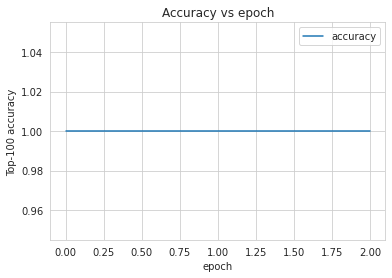

In [291]:
epochs = [i for i in range(3)]

plt.plot(epochs, modelhist_dcn.history["factorized_top_k/top_100_categorical_accuracy"], label="accuracy")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-100 accuracy");
plt.legend()

In [292]:
items = tf.data.Dataset.from_tensor_slices(items_dict)


<Figure size 648x648 with 0 Axes>

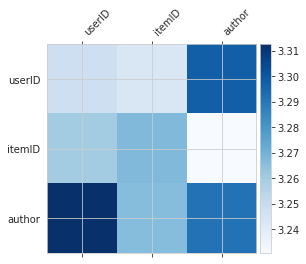

In [293]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

## access the kernel inside cross-network in the first later of the sequential layer in querymodel
mat = model.query_model.dense_layers.get_layer(index=0)._dense.kernel
features =  ['userID', 
            'itemID',
            'author']

block_norm = np.ones([len(features), len(features)])

dim = model.query_model.embedding_model.embedding_dimension

# Compute the norms of the blocks.
for i in range(len(features)):
    for j in range(len(features)):
        block = mat[i * dim:(i + 1) * dim,
                    j * dim:(j + 1) * dim]
        block_norm[i,j] = np.linalg.norm(block, ord="fro")

plt.figure(figsize=(9,9))
im = plt.matshow(block_norm, cmap=plt.cm.Blues)
ax = plt.gca()
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
cax.tick_params(labelsize=10) 
_ = ax.set_xticklabels([""] + features, rotation=45, ha="left", fontsize=10)
_ = ax.set_yticklabels([""] + features, fontsize=10)